In [1]:
# DataFrame
import pandas as pd 

# plotting
import seaborn as sns
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# nltk
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

# sklearn
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix, classification_report

from sklearn.metrics import precision_score, recall_score, f1_score


#tensorflow
import tensorflow as tf
from tensorflow import keras
import tensorflow_datasets as tfds
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, TensorBoard

# Utility
import numpy as np 
import warnings
warnings.filterwarnings('ignore')
import re
import string
import pickle

# Loading Data

In [2]:
data = pd.read_csv(
    "C:/Users/andyr/OneDrive/Desktop/tweet-sentiment.csv", encoding='latin-1')
data.head()

,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer. You shoulda got David Carr of Third Day to do it. ;D"
0,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
1,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
2,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
3,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."
4,0,1467811372,Mon Apr 06 22:20:00 PDT 2009,NO_QUERY,joy_wolf,@Kwesidei not the whole crew


In [3]:
# Set Sample size

data = data.sample(frac=1)
data = data[:100000]

# Data Visualization

In [4]:
print("Dataset shape:", data.shape)

Dataset shape: (100000, 6)


1,599,999 rows and 6 columns

In [5]:
# Add column headers
DATASET_COLUMNS = ["target", "ids", "date", "flag", "user", "TweetText"]
data.columns = DATASET_COLUMNS
data.head()

,target,ids,date,flag,user,TweetText
728560,0,2263097529,Sat Jun 20 23:57:01 PDT 2009,NO_QUERY,PrincessMir,@ahmedzainal boy trouble
839543,4,1559451858,Sun Apr 19 11:10:34 PDT 2009,NO_QUERY,tera9316,sitting at angies with jess
182668,0,1967206489,Fri May 29 19:09:41 PDT 2009,NO_QUERY,KaylaaSyko,have not been on in a while.Today i found out ...
1077166,4,1967621565,Fri May 29 19:55:02 PDT 2009,NO_QUERY,elysiabrooker,@BrendanWenzel Awww thanks Brendan You rock! ...
90102,0,1755663894,Sun May 10 09:42:46 PDT 2009,NO_QUERY,inaccuratemap,@recordskip it says it's a protected entry an...


In [6]:
data.describe()

,target,ids
count,100000.00000,1.000000e+05
mean,2.00072,1.999185e+09
std,2.00001,1.935060e+08
min,0.00000,1.467812e+09
25%,0.00000,1.956799e+09
50%,4.00000,2.002257e+09
75%,4.00000,2.177190e+09
max,4.00000,2.329200e+09


In [7]:
# Drop columns
data = data[["target", "TweetText"]]
data.sample(5)

,target,TweetText
449901,0,@mcj66 it's mortifyingly embarassing tho not s...
1101439,4,Grad parties all day
1185834,4,@emilywilliams Haha
1473467,4,@LisaHopeCyrus wow. im laughing for the first ...
98998,0,Future of the Left play Brighton tonight! Slac...


In [8]:
data.target = data['target'].replace(4, 1)

In [9]:
# check the number of positive vs. negative tagged sentences
positives = data['target'][data.target == 1]
negatives = data['target'][data.target == 0]

print('Total length of the data is:         {}'.format(data.shape[0]))
print('No. of positve tagged sentences is:  {}'.format(len(positives)))
print('No. of negative tagged sentences is: {}'.format(len(negatives)))

Total length of the data is:         100000
No. of positve tagged sentences is:  50018
No. of negative tagged sentences is: 49982


In [10]:
# get a word count per of TweetText
def word_count(words):
    return len(words.split())

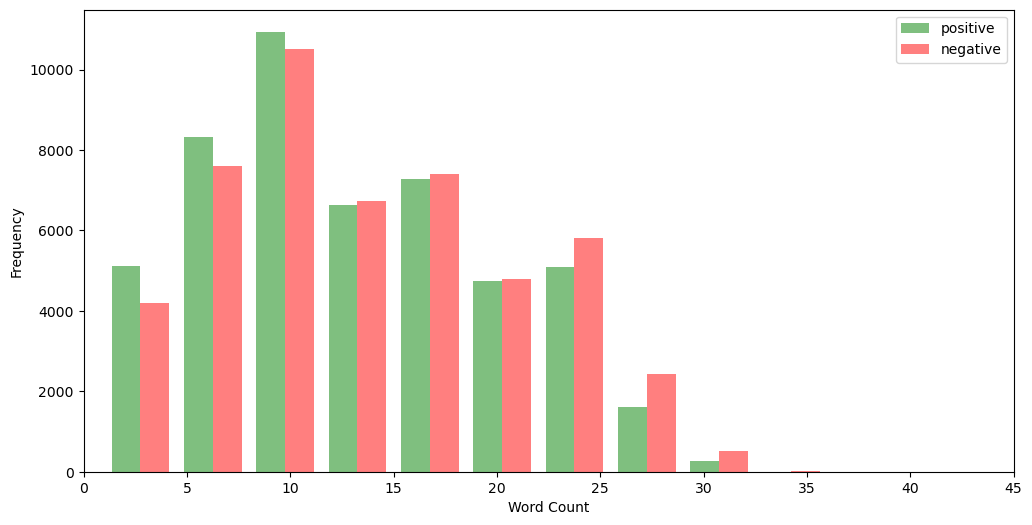

In [11]:
# plot word count distribution for both positive and negative

data['word count'] = data['TweetText'].apply(word_count)
p = data['word count'][data.target == 1]
n = data['word count'][data.target == 0]
plt.figure(figsize=(12, 6))
plt.xlim(0, 45)
plt.xlabel('Word Count')
plt.ylabel('Frequency')
g = plt.hist([p, n], color=['g', 'r'], alpha=0.5,
             label=['positive', 'negative'])
plt.legend(loc='upper right')

In [12]:
# get common words in training dataset
from collections import Counter
all_words = []
for line in list(data['TweetText']):
    words = line.split()
    for word in words:
        if(len(word) > 2):
            all_words.append(word.lower())


Counter(all_words).most_common(20)

[('the', 32699),
 ('and', 18553),
 ('you', 14786),
 ('for', 13489),
 ('have', 8917),
 ('that', 8168),
 ("i'm", 7971),
 ('just', 7826),
 ('but', 7713),
 ('with', 7143),
 ('was', 6440),
 ('not', 6239),
 ('this', 5492),
 ('get', 5051),
 ('good', 4796),
 ('are', 4775),
 ('like', 4763),
 ('all', 4703),
 ('out', 4284),
 ("it's", 4055)]

# Data Cleaning

In [13]:
nltk.download('wordnet')
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\andyr\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\andyr\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [14]:
# Lower Casing: Each text is converted to lowercase.
# Removing URLs: Links starting with "http" or "https" or "www" are replaced by "".
# Removing Usernames: Replace @Usernames with word "". (eg: "@XYZ" to "")
# Removing Short Words: Words with length less than 2 are removed.
# Removing Stopwords: Stopwords are the English words which does not add much meaning to a sentence. They can safely be ignored without sacrificing the meaning of the sentence. (eg: "the", "he", "have")
# Lemmatizing: Lemmatization is the process of converting a word to its base form. (e.g: “wolves” to “wolf”)

stop_words = set(stopwords.words('english'))

urlPattern = r"((http://)[^ ]*|(https://)[^ ]*|( www\.)[^ ]*)"
userPattern = '@[^\s]+'


def preprocess_tweettext(tweet):
    # Convert to lowercase
    tweet = tweet.lower()
    # Removing all URls
    tweet = re.sub(urlPattern, '', tweet)
    # Removing all @username.
    tweet = re.sub(userPattern, '', tweet)
    # Remove punctuations
    tweet = tweet.translate(str.maketrans("", "", string.punctuation))
    # tokenizing words
    tokens = word_tokenize(tweet)
    # Remove stop words
    final_tokens = [w for w in tokens if w not in stop_words]
    # reducing a word to its word stem
    wordLemm = WordNetLemmatizer()
    finalwords = []
    for w in final_tokens:
        if len(w) > 1:
            word = wordLemm.lemmatize(w)
            finalwords.append(word)
    return ' '.join(finalwords)

# Analyzing Data

In [15]:
# Preprocess Data
data['preprocess_tweettext'] = data['TweetText'].apply(
    lambda x: preprocess_tweettext(x))
print('Preprocessing complete.')

Preprocessing complete.


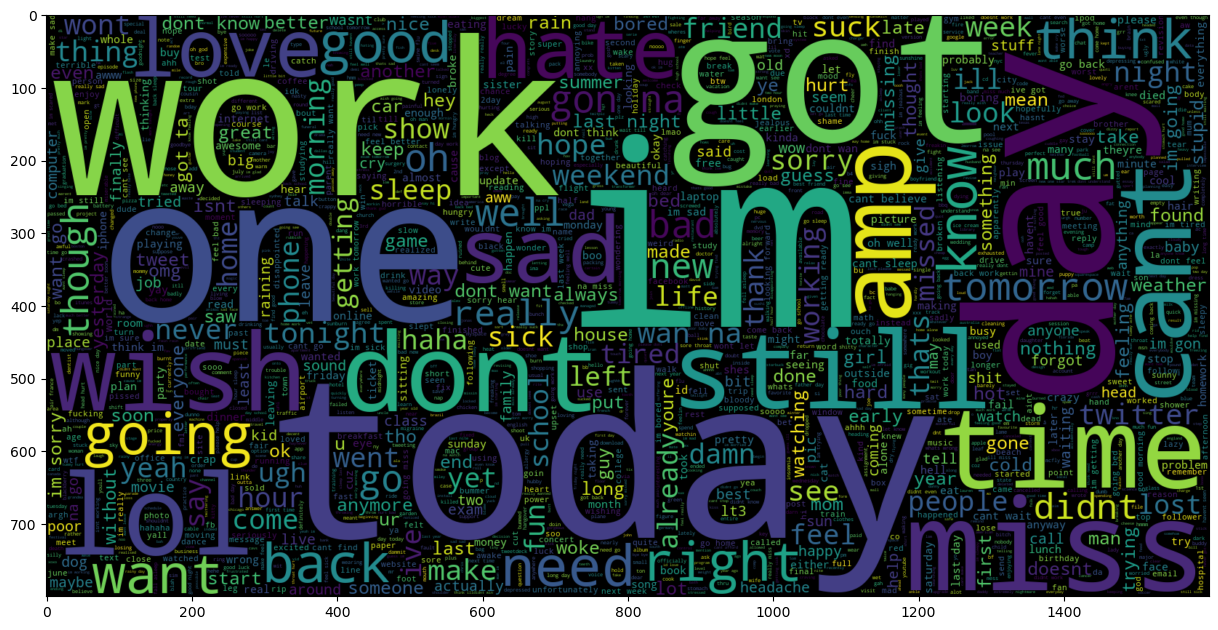

In [16]:
# Negative Tweets
plt.figure(figsize=(15, 15))
wc = WordCloud(max_words=2000, width=1600, height=800).generate(
    " ".join(data[data.target == 0].preprocess_tweettext))
plt.imshow(wc, interpolation='bilinear')

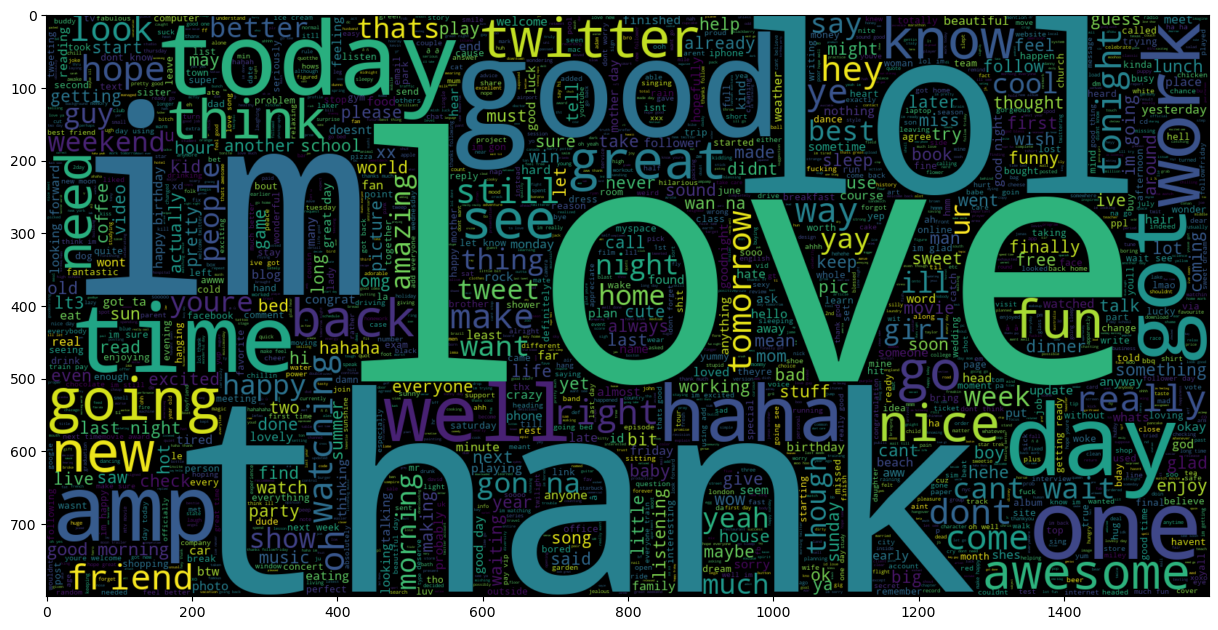

In [17]:
# Positive Tweets
plt.figure(figsize=(15, 15))
wc = WordCloud(max_words=2000, width=1600, height=800).generate(
    " ".join(data[data.target == 1].preprocess_tweettext))
plt.imshow(wc, interpolation='bilinear')

- Vectorization and Splitting the data 
- Storing input variable-processes_tweets to X and output variable-polarity to y

In [18]:
# Assign the preprocessed text and target values
X = data['preprocess_tweettext'].values.astype(str)
y = data['target'].values

Convert text to word frequency vectors
- TF-IDF
- This is an acronym than stands for Term Frequency – Inverse Document Frequency which are the components of the resulting scores assigned to each word.

The Preprocessed Data is divided into 2 sets of data:

- Training Data: The dataset upon which the model would be trained on. Contains 80% data.
- Test Data: The dataset upon which the model would be tested against. Contains 20% data

In [19]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)

# Create a TfidfVectorizer object
vectorizer = TfidfVectorizer(sublinear_tf=True)

# Convert the collection of raw documents to a matrix of TF-IDF features
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

print('Train set shape:', X_train_tfidf.shape)
print('Test set shape:', X_test_tfidf.shape)
print(f'Vector fitted.')
print('No. of feature words:', len(vectorizer.vocabulary_))

Train set shape: (80000, 54970)
Test set shape: (20000, 54970)
Vector fitted.
No. of feature words: 54970


# Model Building

In [20]:
max_words = 2500
max_len = 100

# Tokenize the text data
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(data.preprocess_tweettext)
sequences = tokenizer.texts_to_sequences(data.preprocess_tweettext)
tweets = pad_sequences(sequences, maxlen=max_len)
print(tweets)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    tweets, data.target.values, test_size=0.2, random_state=101)

# Define the model architecture
model2 = Sequential()
model2.add(layers.Embedding(max_words, 128))
model2.add(layers.LSTM(64, dropout=0.5))
model2.add(layers.Dense(16, activation='relu'))
model2.add(layers.Dense(8, activation='relu'))
model2.add(layers.Dense(1, activation='sigmoid'))

# Compile the model
model2.compile(optimizer='adam', loss='binary_crossentropy',
               metrics=['accuracy'])

# Define callbacks for saving the best model, early stopping, and TensorBoard
checkpoint2 = ModelCheckpoint("rnn_model.hdf5", monitor='val_accuracy', verbose=1,
                              save_best_only=True, mode='auto', save_freq=1, save_weights_only=False)
early_stopping = EarlyStopping(monitor='val_loss', patience=3)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2)
tensorboard_callback = TensorBoard(log_dir='./logs')

# Train the model without using batches and with TensorBoard visualization
history = model2.fit(X_train, y_train, batch_size=len(X_train), epochs=50, validation_data=(
    X_test, y_test), callbacks=[checkpoint2, early_stopping, reduce_lr, tensorboard_callback])

[[   0    0    0 ...    0  242  938]
 [   0    0    0 ...    0    0  324]
 [   0    0    0 ...   34   11    4]
 ...
 [   0    0    0 ...  152  271   11]
 [   0    0    0 ...    0  231  150]
 [   0    0    0 ...    0    0 2462]]
Epoch 1/50
1/1 [==============================] - 71s 71s/step - loss: 0.6931 - accuracy: 0.5002 - val_loss: 0.6928 - val_accuracy: 0.5591 - lr: 0.0010
Epoch 2/50
1/1 [==============================] - 58s 58s/step - loss: 0.6928 - accuracy: 0.5345 - val_loss: 0.6921 - val_accuracy: 0.5883 - lr: 0.0010
Epoch 3/50
1/1 [==============================] - 53s 53s/step - loss: 0.6923 - accuracy: 0.5633 - val_loss: 0.6912 - val_accuracy: 0.5994 - lr: 0.0010
Epoch 4/50
1/1 [==============================] - 56s 56s/step - loss: 0.6915 - accuracy: 0.5829 - val_loss: 0.6903 - val_accuracy: 0.5987 - lr: 0.0010
Epoch 5/50
1/1 [==============================] - 52s 52s/step - loss: 0.6905 - accuracy: 0.5902 - val_loss: 0.6893 - val_accuracy: 0.6021 - lr: 0.0010
Epoch 6/50
1

Epoch 35/50
1/1 [==============================] - 54s 54s/step - loss: 0.5375 - accuracy: 0.7423 - val_loss: 0.5387 - val_accuracy: 0.7423 - lr: 0.0010
Epoch 36/50
1/1 [==============================] - 57s 57s/step - loss: 0.5313 - accuracy: 0.7479 - val_loss: 0.5329 - val_accuracy: 0.7448 - lr: 0.0010
Epoch 37/50
1/1 [==============================] - 55s 55s/step - loss: 0.5258 - accuracy: 0.7496 - val_loss: 0.5304 - val_accuracy: 0.7442 - lr: 0.0010
Epoch 38/50
1/1 [==============================] - 70s 70s/step - loss: 0.5238 - accuracy: 0.7487 - val_loss: 0.5272 - val_accuracy: 0.7469 - lr: 0.0010
Epoch 39/50
1/1 [==============================] - 59s 59s/step - loss: 0.5181 - accuracy: 0.7519 - val_loss: 0.5244 - val_accuracy: 0.7483 - lr: 0.0010
Epoch 40/50
1/1 [==============================] - 69s 69s/step - loss: 0.5145 - accuracy: 0.7540 - val_loss: 0.5217 - val_accuracy: 0.7480 - lr: 0.0010
Epoch 41/50
1/1 [==============================] - 64s 64s/step - loss: 0.5121 - a

Open TensorBoard in Anaconda Prompt - http://localhost:6006/

Performance on the test set and display various metrics such as accuracy, precision, recall, and F1-score

In [21]:
# Evaluate the model on the test set
loss, accuracy = model2.evaluate(X_test, y_test)

# Make predictions on the test set
predictions = model2.predict(X_test)
binary_predictions = [1 if pred > 0.5 else 0 for pred in predictions]

# Calculate additional evaluation metrics
precision = precision_score(y_test, binary_predictions)
recall = recall_score(y_test, binary_predictions)
f1 = f1_score(y_test, binary_predictions)

# Display the results
print("Test Set Results:")
print("Loss: {:.4f}".format(loss))
print("Accuracy: {:.4f}".format(accuracy))
print("Precision: {:.4f}".format(precision))
print("Recall: {:.4f}".format(recall))
print("F1-Score: {:.4f}".format(f1))

625/625 [==============================] - 8s 12ms/step
Test Set Results:
Loss: 0.5072
Accuracy: 0.7570
Precision: 0.7470
Recall: 0.7843
F1-Score: 0.7652
